# Lab: Categorize Text with NLP

> In this lab, you will use machine learning and Natural Language Processing (NLP) to classify consumer complaints. You will classify consumer complaints by building a binary classification model, then a multiclass classification model. 

## EDA, check data quality

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from rich import print
from rich.table import Table

from helpers import df_to_table

In [2]:
binary_complaints_raw = pd.read_csv("data/complaints_binary.csv")

In [3]:
print(f"""Rows, cols: {binary_complaints_raw.shape}

Columns = {binary_complaints_raw.columns.to_list()}
""")

Rows, cols: (3243, 7)

Columns = ['Product', 'Company public response', 'State', 'Consumer consent provided?', 'Date
received', 'Consumer disputed?', 'Consumer complaint narrative']

In [4]:
binary_complaints_raw.describe()

,Product,Company public response,State,Consumer consent provided?,Date received,Consumer disputed?,Consumer complaint narrative
count,3243,942,3189,3243,3243,3243,3243
unique,2,9,55,1,722,2,3236
top,Payday loan,Company believes it acted appropriately as aut...,CA,Consent provided,2015-10-21,No,fees and payments were different than what the...
freq,1746,311,479,3243,14,2704,2


In [5]:
binary_complaints_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3243 entries, 0 to 3242
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       3243 non-null   object
 1   Company public response       942 non-null    object
 2   State                         3189 non-null   object
 3   Consumer consent provided?    3243 non-null   object
 4   Date received                 3243 non-null   object
 5   Consumer disputed?            3243 non-null   object
 6   Consumer complaint narrative  3243 non-null   object
dtypes: object(7)
memory usage: 177.5+ KB


In [6]:
cols = binary_complaints_raw.columns.to_list()
for column in cols[:-1]:  # exclude customer complaints
    print(f"{binary_complaints_raw[column].value_counts()}\n")

Payday loan        1746
Money transfers    1497
Name: Product, dtype: int64

Company believes it acted appropriately as authorized by contract or law                     
311
Company has responded to the consumer and the CFPB and chooses not to provide a public 
response                            216
Company chooses not to provide a public response                                             
136
Company believes complaint caused principally by actions of third party outside the control 
or direction of the company    100
Company disputes the facts presented in the complaint                                        
93
Company believes the complaint is the result of a misunderstanding                           
29
Company believes complaint is the result of an isolated error                                
25
Company can't verify or dispute the facts in the complaint                                   
20
Company believes complaint represents an opportunity for improvement to better serve 
consumers                              12
Name: Company public response, dtype: int64

CA    479
TX    332
FL    222
NY    130
VA    126
OH    122
GA    119
MD    101
IL    100
TN     92
PA     91
NJ     87
MI     77
WA     75
NC     74
MA     66
AZ     63
MO     61
NV     55
LA     55
IN     52
MN     47
CO     47
OK     46
SC     43
AL     37
OR     33
WI     33
KY     32
NM     28
KS     23
CT     21
IA     20
UT     19
DC     18
ME     16
ID     14
NE     14
MS     13
RI     12
NH     12
HI     11
DE     11
AR      8
WV      8
SD      7
AK      7
PR      6
MT      6
ND      5
WY      4
VT      4
AE      3
MP      1
AP      1
Name: State, dtype: int64

Consent provided    3243
Name: Consumer consent provided?, dtype: int64

2015-10-21    14
2015-07-29    13
2016-10-11    13
2015-06-05    12
2016-11-04    12
              ..
2015-06-21     1
2015-03-20     1
2017-02-26     1
2016-07-04     1
2016-05-08     1
Name: Date received, Length: 722, dtype: int64

No     2704
Yes     539
Name: Consumer disputed?, dtype: int64

## Set DataRobot project

In [7]:
import altair as alt
import datarobot as dr
import os

from datarobot.errors import ClientError

dr.Client(
    endpoint=os.getenv("DATAROBOT_ENDPOINT"),
    token=os.getenv("DATAROBOT_TOKEN")
)

In [8]:
def check_project_exist(project_name: str):
    if project_name in [i.project_name for i in  dr.Project.list()]:
        return(True, ([i for i in  dr.Project.list() if i.project_name == project_name][0]))
    else:
        raise ValueError(f"No project called {project_name}")

In [9]:
_project = check_project_exist("nlp-classification-lab")[1] if check_project_exist("nlp-classification-lab")[0] else None

In [10]:
# %%time

"if project exists, do not run this cell, it will create a duplicate"

# binary_dataset = dr.Dataset.create_from_in_memory_data(binary_complaints_raw)

# _project = dr.Project.create_from_dataset(
#     binary_dataset.id, 
#     project_name="nlp-classification-lab"
# )

# _project.set_target(
#     target="Product",
#     # target_type=dr.enums.TARGET_TYPE.BINARY,
#     mode="manual",
#     worker_count=-1,
# )

'if project exists, do not run this cell, it will create a duplicate'

In [11]:
_project_url = f"https://app.eu.datarobot.com/projects/{_project.id}"

### DataRobot NLP models

> While running AutoPilot, DataRobot will try a number of different types of NLP models.

The most common model DataRobot uses is the Auto-Tuned modeler. These blueprints automatically select the appropriate n-gram to get the best performance.  

Another approach is the matrix of word grams. Blueprints that contain these pre-processing steps create a matrix of word-gram occurrences, which are then used to perform a text fit on the residuals

These blueprints are highly tunable using Advanced Tuning.

There are also DataRobot blueprints that use word vectors with a step called “Fasttext.” [Fasttext](https://fasttext.cc/) is a library for efficient learning of word representations that comes in two flavors, CBOW (Continuous Bag of Words Model) and Skip-Gram.  

****

### Binary classification

In [12]:
models = [i for i in _project.get_models()]
scores = [(i.model_type, i.metrics["LogLoss"]["validation"]) for i in _project.get_models()]

In [13]:
_df = pd.DataFrame(scores, columns=["model", "logloss-score"])
_plot = alt.Chart(_df).mark_bar().encode(
    x=alt.X("model:N", sort="-y", title=None),
    y="logloss-score:Q",
    tooltip=["model:N", "logloss-score:Q"]
).properties(width=600, height=325, title="Data Robot auto generated models")

_plot

alt.Chart(...)

In [14]:
_fasttext_blueprints = [i for i in _project.get_blueprints() if "Fasttext" in str(i.processes)]

[_project.train(i) for i in _fasttext_blueprints]

print(f"Fasttext models {_fasttext_blueprints}")

models = [i for i in _project.get_models()]

Fasttext models [Blueprint(Elastic-Net Classifier (L2 / Binomial Deviance)), 
Blueprint(eXtreme Gradient Boosted Trees Classifier)]

In [15]:
[i.cross_validate() for i in models if i.metrics["LogLoss"]["crossValidation"] is None]

[]

In [16]:
len(_project.get_all_jobs())  # if 0 then finished cross-validation

0

In [17]:
models = [i for i in _project.get_models()]
scores = [(i.model_type, i.metrics["LogLoss"]["crossValidation"]) for i in models]
_df = pd.DataFrame(scores, columns=["model", "logloss-score"])
_df = _df.assign(
    is_fasttext_model=[1 if "Fasttext" in str(i.processes) else 0 for i in models],
    id=[i.id for i in models]
)

_plot = alt.Chart(_df).mark_bar().encode(
    x=alt.X("model:N", sort="-y", title=None),
    y="logloss-score:Q",
    color="is_fasttext_model:N",
    tooltip=["model:N", "logloss-score:Q"]
).properties(width=600, height=325, title="Data Robot auto generated models")

_plot

alt.Chart(...)

In [18]:
top_fasttext_model_id = _df[_df.is_fasttext_model == 1].sort_values(by="logloss-score", ascending=False)["id"].iloc[0]
top_fasttext_model = [i for i in models if i.id == top_fasttext_model_id][0]

In [19]:
# ignore the rule based model, get the top model based on cross validation using LogLoss
top_model = [i for i in models if i.id == _df.sort_values(by="logloss-score", ascending=False)["id"].iloc[1]][0]

print("Methods used by the top model:")
print(top_model.processes)

Methods used by the top model:

[
    'One-Hot Encoding',
    'Numeric Data Cleansing',
    'Smooth Ridit Transform',
    'Matrix of word-grams occurrences using tfidf',
    'Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 
Units)'
]

In [20]:
_features = top_model.get_or_request_feature_impact()
feature_df = pd.DataFrame(_features)

(
    alt.Chart(feature_df).mark_bar()
    .encode(
        x="impactNormalized:Q",
        y=alt.Y("featureName", sort="-x"),
    )
    .properties(
        width=450,
        height=400,
        title="Top features"
    )
)

alt.Chart(...)

In [21]:
print("Clearly text classication from the raw complaint is the most important feature. Let's explore that")

Clearly text classication from the raw complaint is the most important feature. Let's explore
that

In [22]:
wordclouds = []
for model in models:
    try:
        wordclouds.append(model.get_word_cloud(exclude_stop_words=True))

    except ClientError as e:
        if e.json['message'] and 'No word cloud data' in e.json['message']:
            pass
        else:
            raise

In [23]:
print(wordclouds[0].most_important(top_n=5))

[
    {
        'ngram': 'loan',
        'coefficient': 1.0,
        'count': 851,
        'frequency': 0.8683673469387755,
        'is_stopword': False,
        'class': None,
        'variable': 'Consumer complaint narrative'
    },
    {
        'ngram': 'paypal',
        'coefficient': -0.5579574018998696,
        'count': 256,
        'frequency': 0.2612244897959184,
        'is_stopword': False,
        'class': None,
        'variable': 'Consumer complaint narrative'
    },
    {
        'ngram': 'transfer',
        'coefficient': -0.524712601156532,
        'count': 424,
        'frequency': 0.4326530612244898,
        'is_stopword': False,
        'class': None,
        'variable': 'Consumer complaint narrative'
    },
    {
        'ngram': 'payday',
        'coefficient': 0.4207728924711484,
        'count': 390,
        'frequency': 0.3979591836734694,
        'is_stopword': False,
        'class': None,
        'variable': 'Consumer complaint narrative'
    },
    {
        'ngram': 'debt',
        'coefficient': 0.3915256298730353,
        'count': 198,
        'frequency': 0.20204081632653062,
        'is_stopword': False,
        'class': None,
        'variable': 'Consumer complaint narrative'
    }
]

In [24]:
_text_mining_df = pd.DataFrame(wordclouds[0].ngrams)
text_mining_df = _text_mining_df.iloc[np.r_[0:8, -8:0]]  # get top 8 and bottom 8
assert text_mining_df.shape[0] == 16
text_mining_df["color_encode"] = [1 if i > 0 else 0 for i in text_mining_df.coefficient.values]

/Users/michael/Library/Caches/pypoetry/virtualenvs/nlp-classification-RsHXGmC2-py3.9/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [25]:
coefficient_plot = (
    alt.Chart(text_mining_df[text_mining_df.is_stopword == False])
    .mark_bar()
    .encode(
        x="coefficient:Q",
        y=alt.Y(
            "ngram:N", 
            sort=alt.SortField(field="coefficient", order="descending")
        ),
        color=alt.Color("color_encode:N", legend=None)
    )
    .properties(
        width=450,
        height=600,
        title="Coefficient of ngram"
    )
)

frequency_plot = (
    alt.Chart(text_mining_df[text_mining_df.is_stopword == False])
    .mark_bar(opacity=0.4, color="crimson")
    .encode(
        x="frequency:Q",
        y=alt.Y(
            "ngram:N", 
            sort=alt.SortField(field="coefficient", order="descending"),
            title=None,
            axis=None
        ),
    )
    .properties(
        width=200,
        height=600,
        title="Frequency of ngram"
    )
)

coefficient_plot | frequency_plot

alt.HConcatChart(...)

In [26]:
from helpers import word_cloud_plot

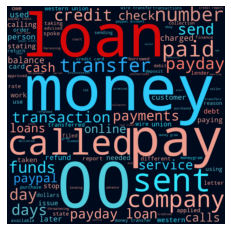

In [27]:
word_cloud_plot(wordclouds[0])

### Multiclass classification

> DataRobot is able to handle up to 100 classes for multiclass projects. 

In [28]:
# _data = pd.read_csv("data/complaints_train.csv")
# _multiclass_dataset = dr.Dataset.create_from_in_memory_data(_data)

In [29]:
%%time

"if project exists, do not run this cell, it will create a duplicate"

# _project = dr.Project.create_from_dataset(
#     _multiclass_dataset.id, 
#     project_name="nlp-multi-classification-lab"
# )

# _project.set_target(
#     target="Product",
#     target_type=dr.enums.TARGET_TYPE.MULTICLASS,
#     mode="quick",
#     worker_count=-1,
# )

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


'if project exists, do not run this cell, it will create a duplicate'

In [30]:
_project = (
    check_project_exist("nlp-multi-classification-lab")[1]
    if check_project_exist("nlp-multi-classification-lab")[0]
    else None
)

In [31]:
from datarobot.models.project import Project
from datarobot.models.model import Model

def run_cross_validation(project: Project):
    [i.cross_validate() for i in project.get_models() if i.metrics["LogLoss"]["crossValidation"] is None]

    return f"Running cross-validation for {len(project.get_all_jobs())} models"  # if 0 then finished cross-validation


def get_top_model(project: Project) -> Model:
    _models = [(i, i.metrics["LogLoss"]["validation"]) for i in _project.get_models() if i.model_type != "RuleFit Classifier"]
    _models.sort(key=lambda x: x[1], reverse=True)
    return _models[0][0]

In [32]:
run_cross_validation(_project)

'Running cross-validation for 1 models'

In [33]:
models = _project.get_models()

In [34]:
tree_classifier = [i for i in models if "Light Gradient Boosted Trees Classifier with Early Stopping" in i.model_type][0]

In [35]:
_features = tree_classifier.get_or_request_feature_impact()
feature_df = pd.DataFrame(_features)

(
    alt.Chart(feature_df).mark_bar()
    .encode(
        x="impactNormalized:Q",
        y=alt.Y("featureName", sort="-x"),
    )
    .properties(
        width=450,
        height=400,
        title="Top features"
    )
)

alt.Chart(...)

In [36]:
_features = tree_classifier.get_multiclass_feature_impact()
_feature_plots = []

for _class in [i["class"] for i in _features]:

    feature_df = pd.DataFrame([i["featureImpacts"] for i in _features if i["class"] == _class][0])


    _feature_plots.append(
        alt.Chart(feature_df).mark_bar()
        .encode(
            x="impactNormalized:Q",
            y=alt.Y("featureName", sort="-x"),
        )
        .properties(
            width=450,
            height=400,
            title=f"Top features when predictiong {_class}"
        )
    )

In [37]:
display(*_feature_plots)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [38]:
top_model = get_top_model(_project)
_lift_charts = top_model.get_all_multiclass_lift_charts()

In [39]:
from helpers import rebin_df, matplotlib_lift

Target Class: Checking or savings account

Target Class: Consumer Loan

Target Class: Credit card

Target Class: Credit card or prepaid card

Target Class: Credit reporting

Target Class: Credit reporting, credit repair services, or other personal consumer reports

Target Class: Debt collection

Target Class: Money transfer, virtual currency, or money service

Target Class: Student loan

Target Class: Vehicle loan or lease

Target Class: Checking or savings account

Target Class: Consumer Loan

Target Class: Credit card

Target Class: Credit card or prepaid card

Target Class: Credit reporting

Target Class: Credit reporting, credit repair services, or other personal consumer reports

Target Class: Debt collection

Target Class: Money transfer, virtual currency, or money service

Target Class: Student loan

Target Class: Vehicle loan or lease

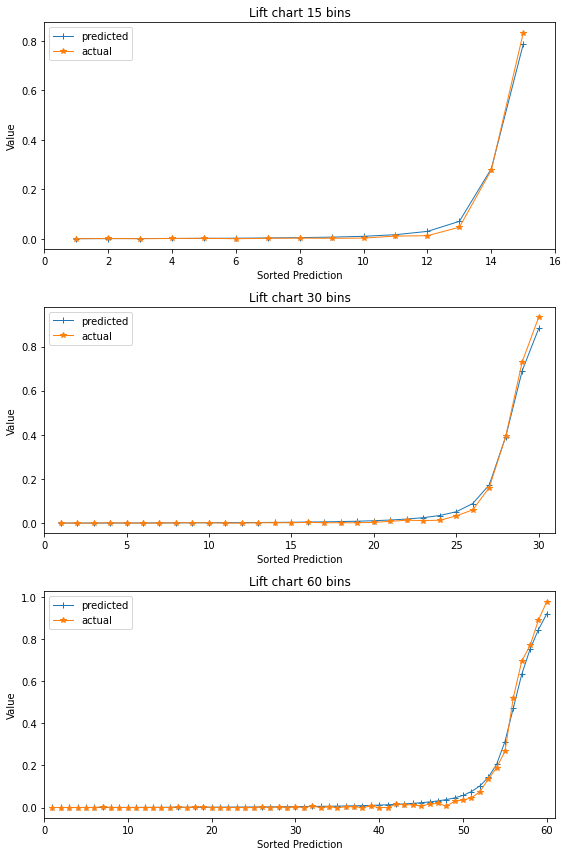

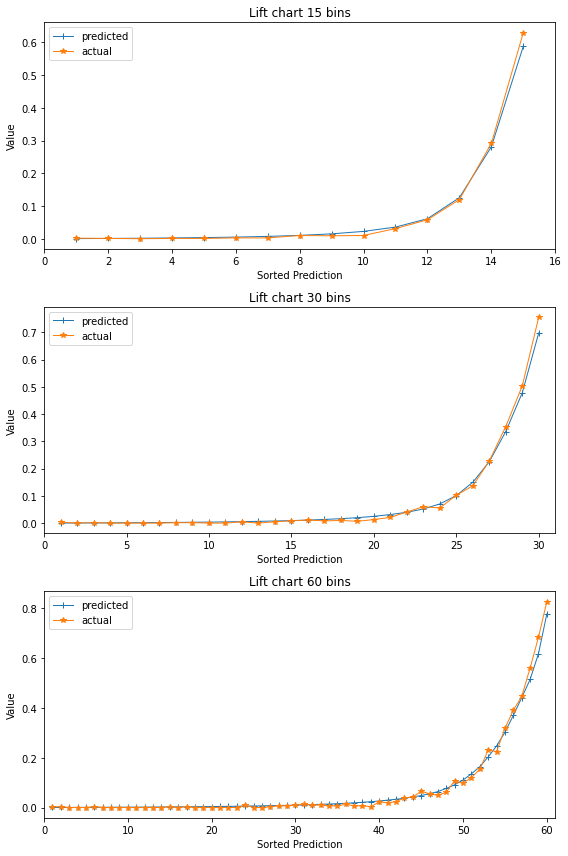

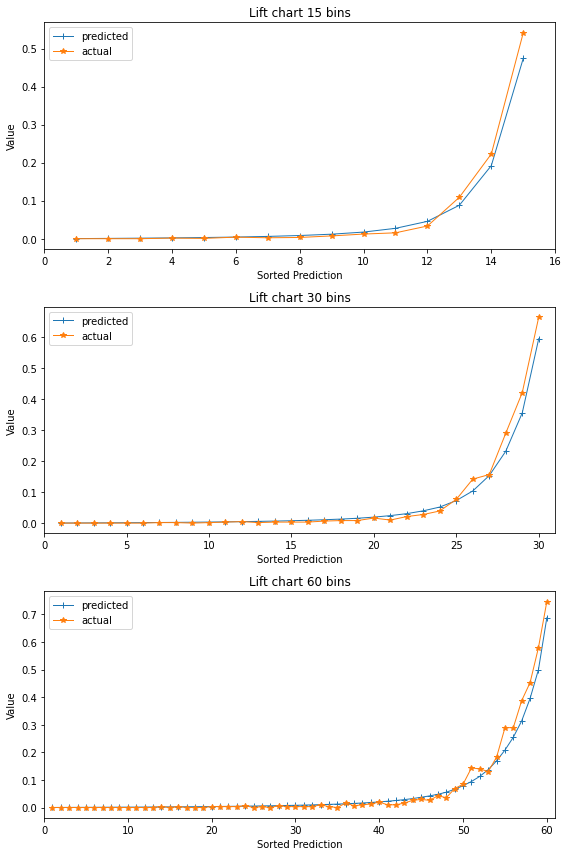

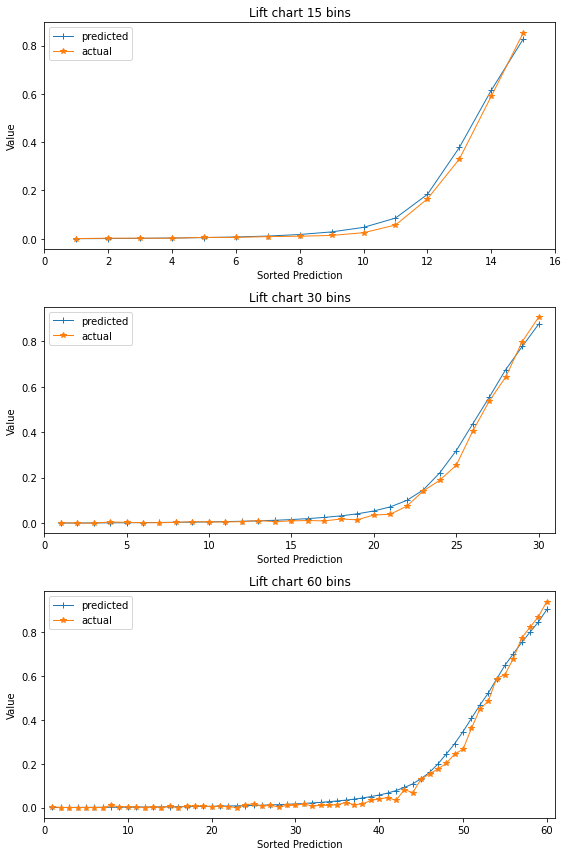

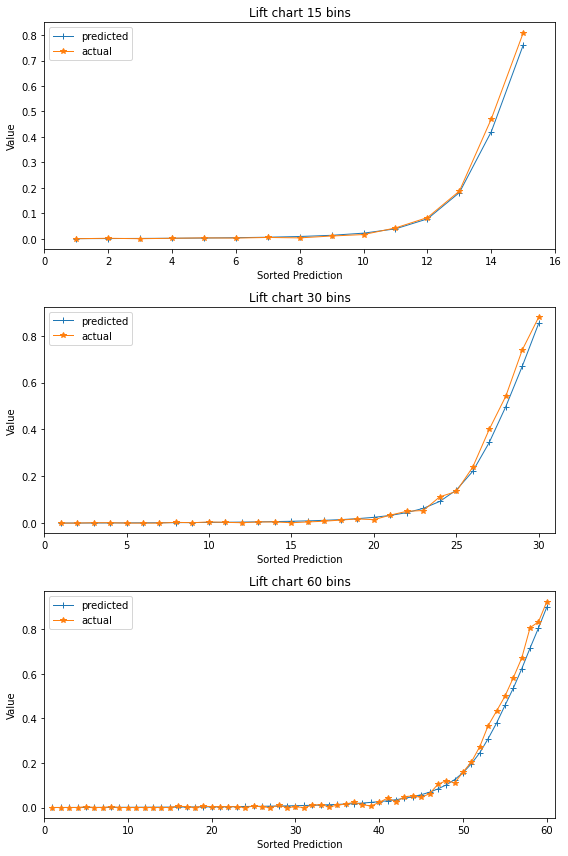

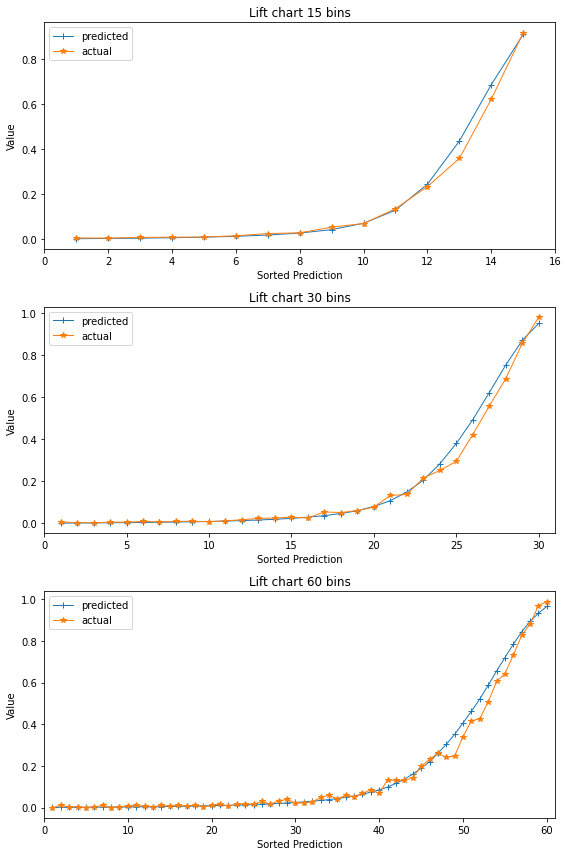

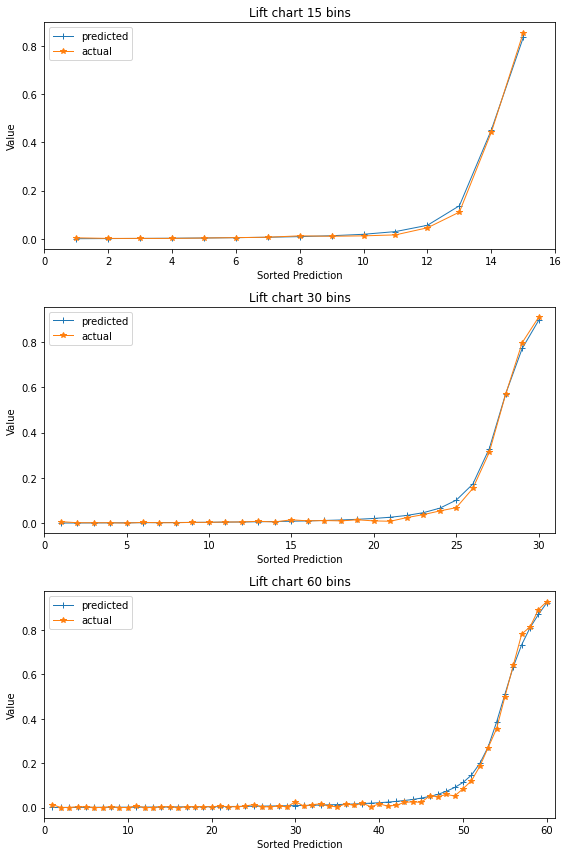

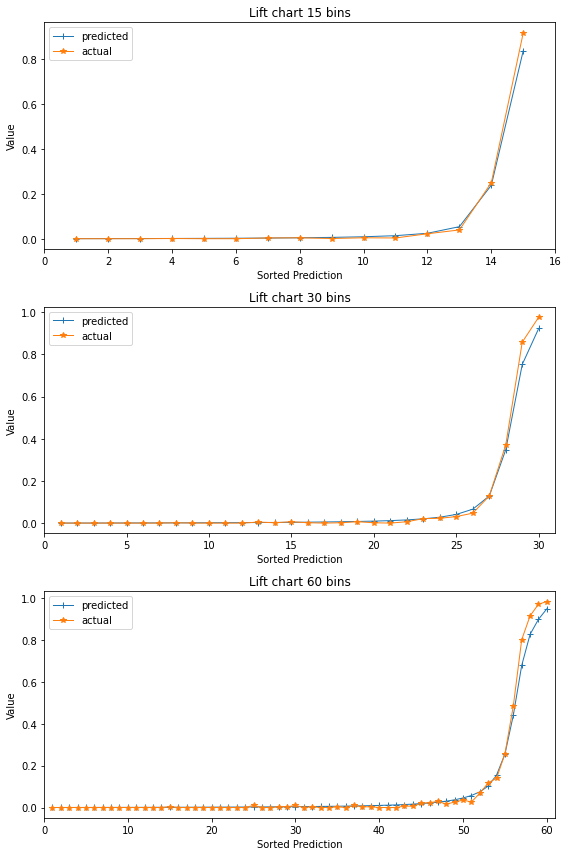

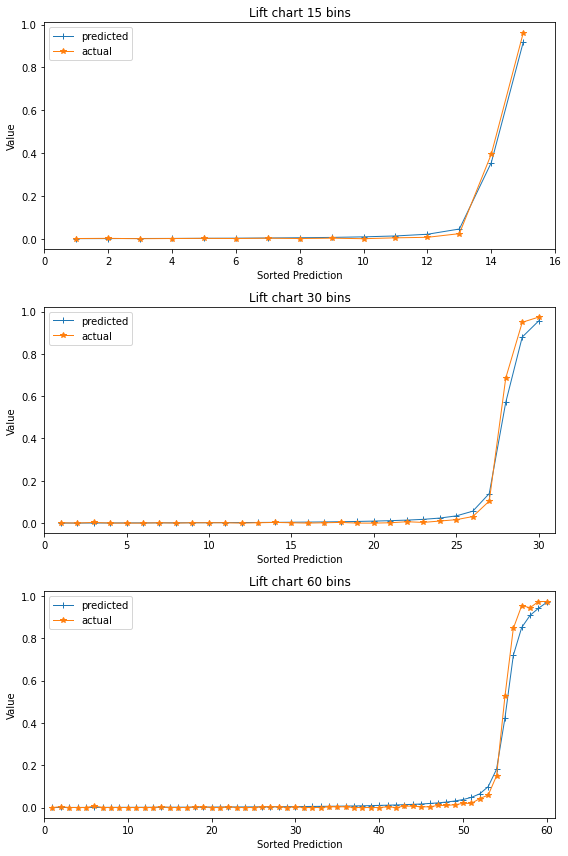

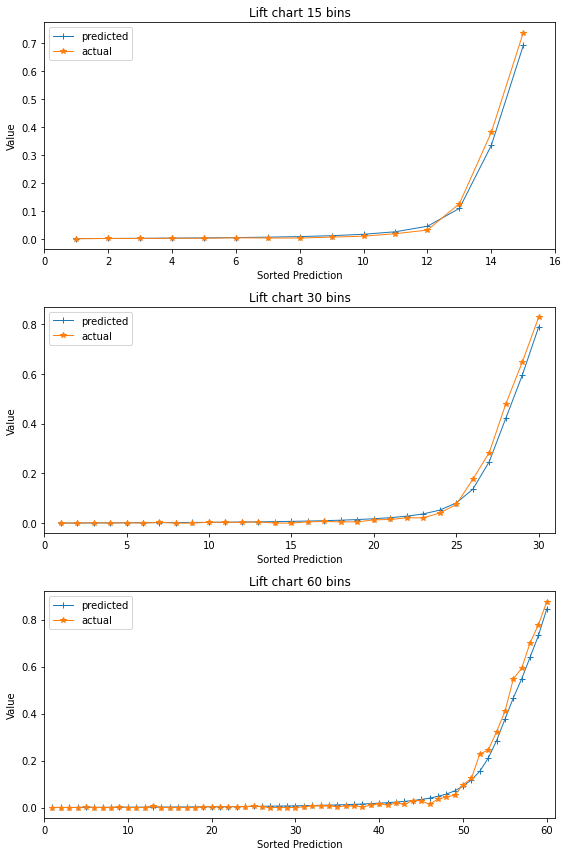

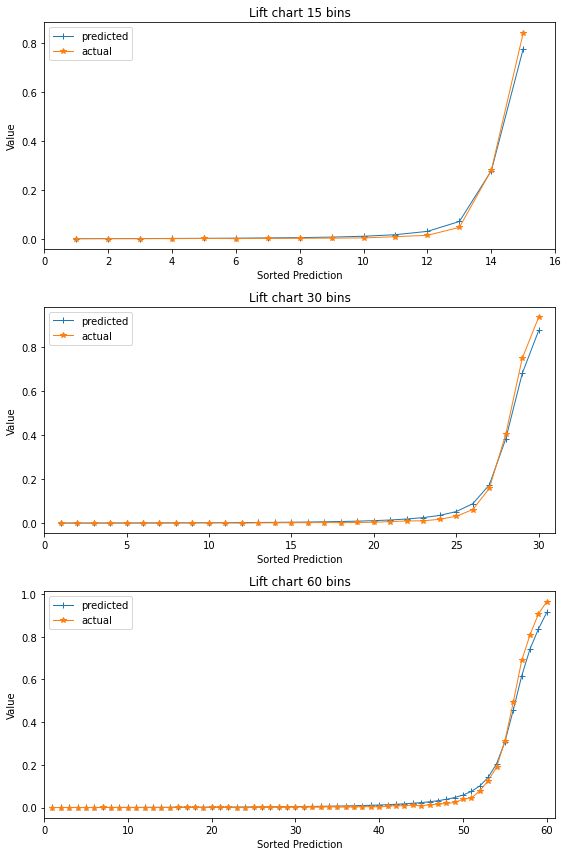

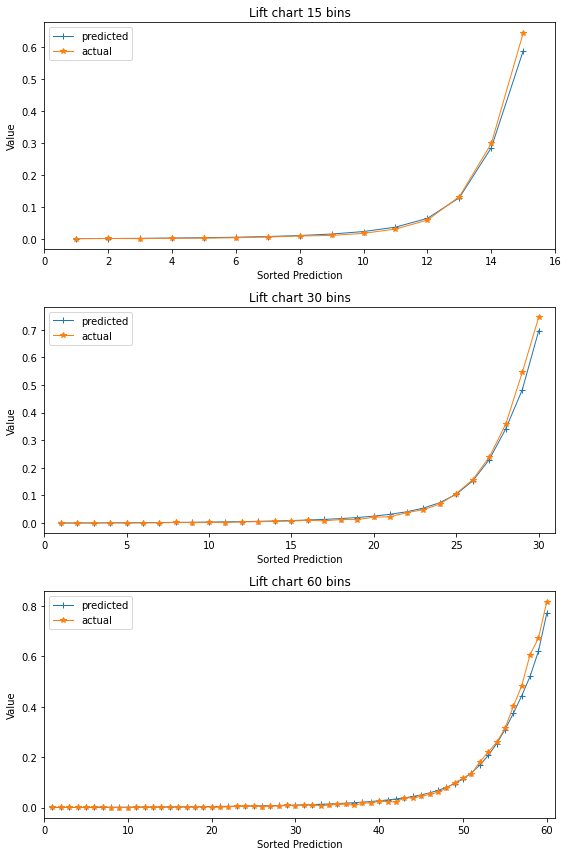

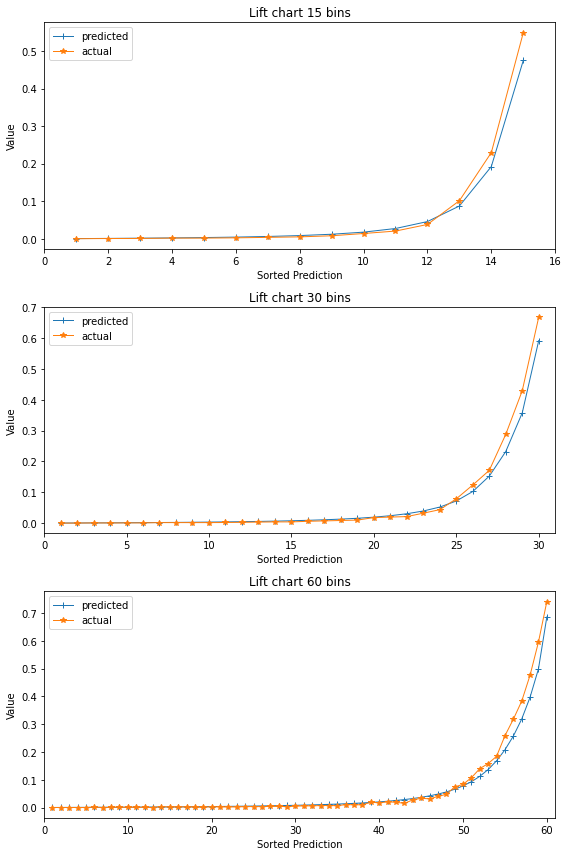

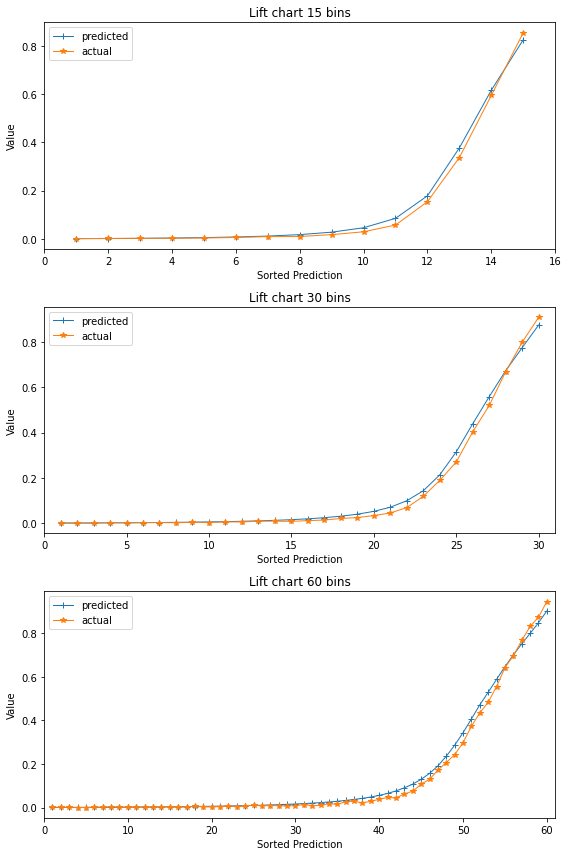

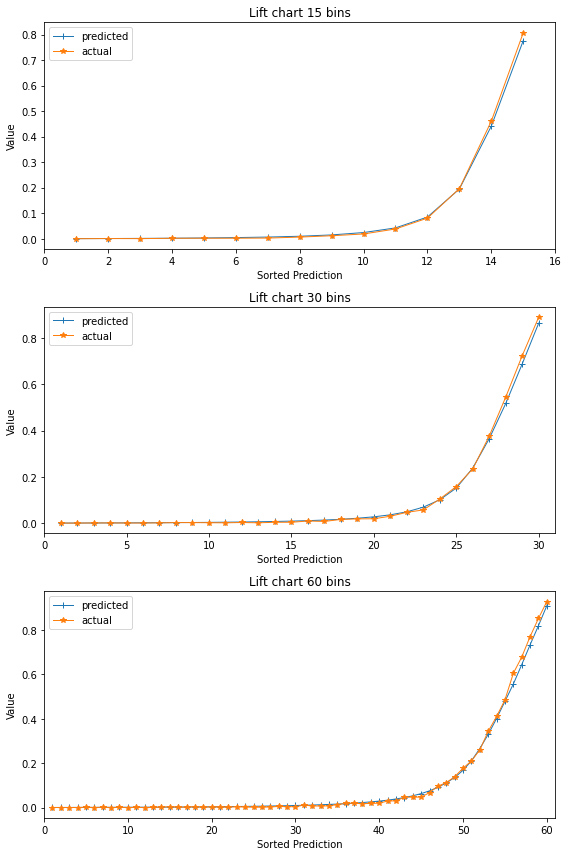

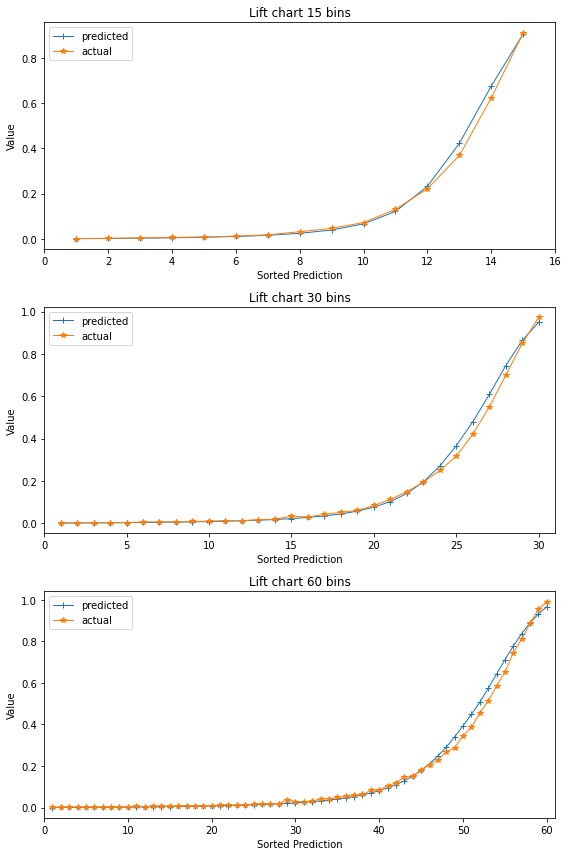

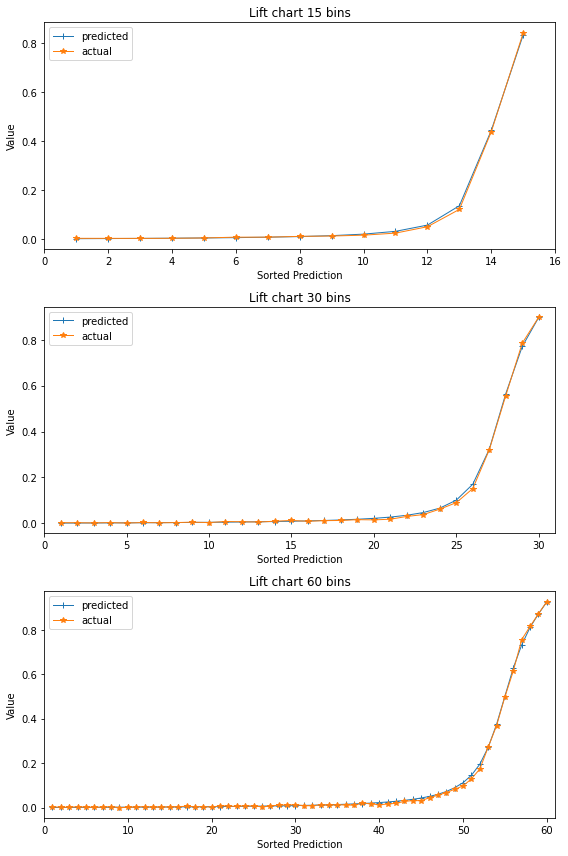

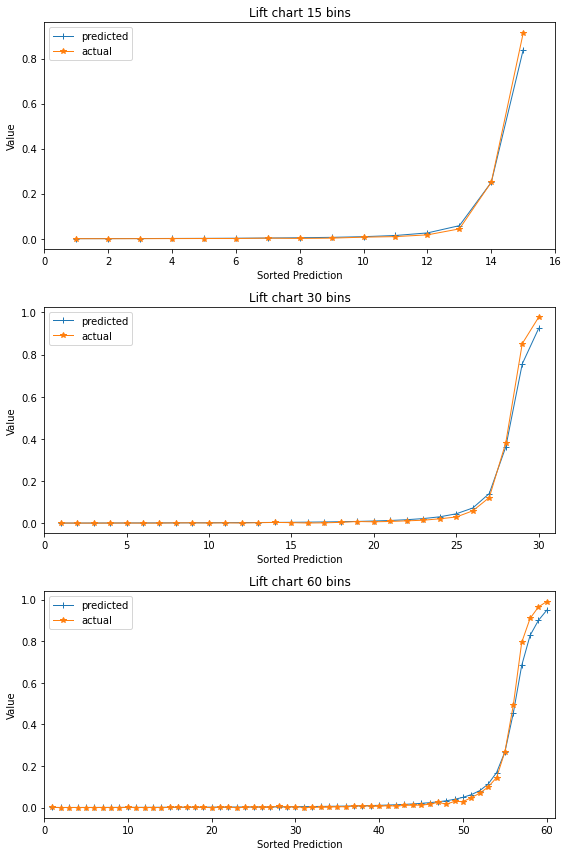

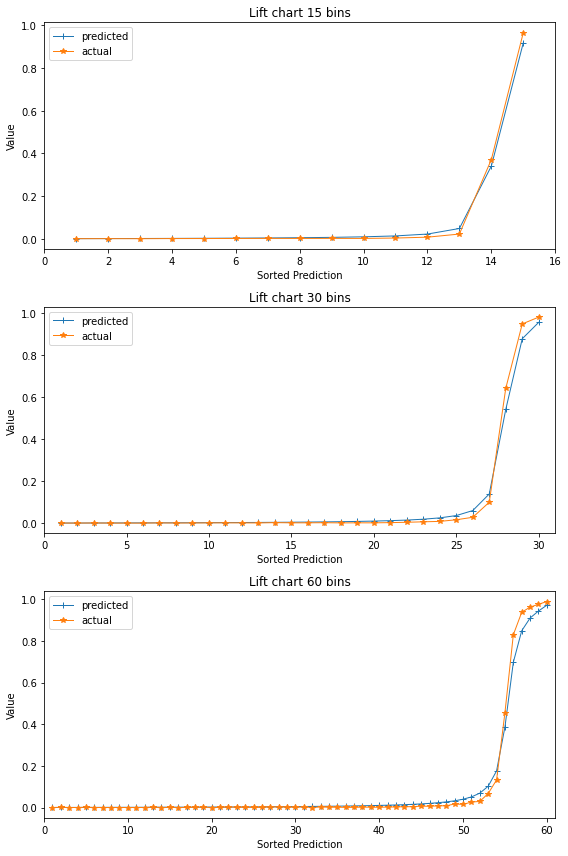

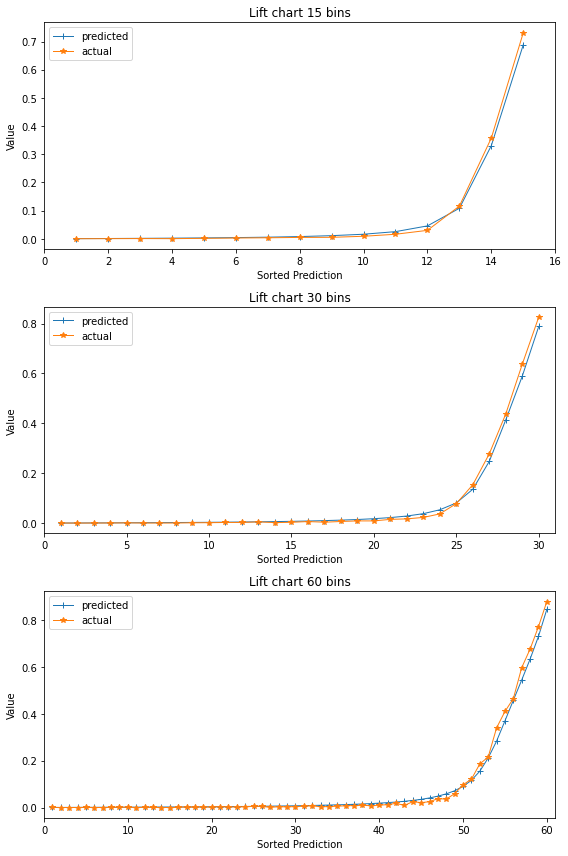

In [40]:
for _chart in _lift_charts:
    raw_df = pd.DataFrame(_chart.bins)

    bin_counts = [15, 30, 60]
    f, axarr = plt.subplots(len(bin_counts))
    f.set_size_inches((8, 4 * len(bin_counts)))

    rebinned_dfs = []
    for i in range(len(bin_counts)):
        rebinned_dfs.append(matplotlib_lift(raw_df, bin_counts[i], axarr[i]))
    print(f"Target Class: {_chart.target_class}")
    plt.tight_layout()

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

_cm = top_model.get_confusion_chart(source="crossValidation")

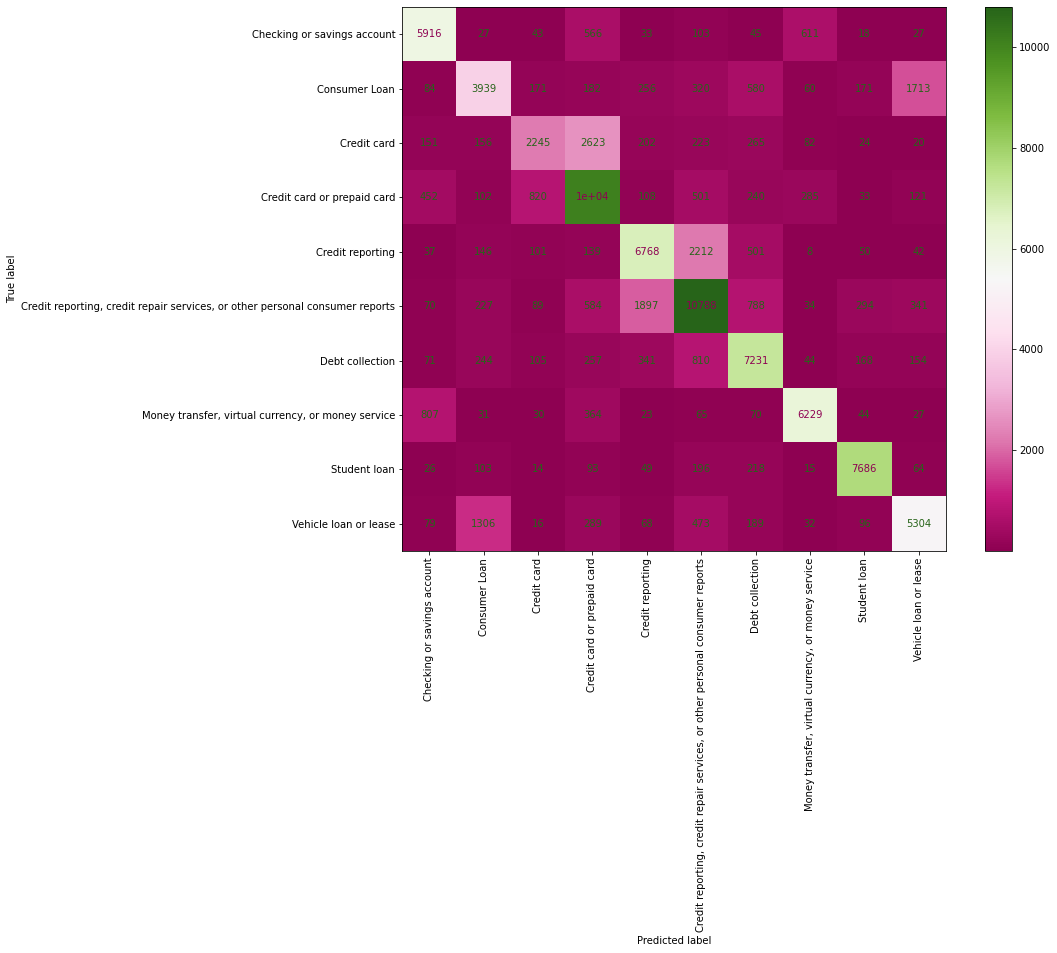

In [42]:
fig, ax = plt.subplots(figsize = (14,10))

ConfusionMatrixDisplay(
    confusion_matrix=np.array(_cm.confusion_matrix), 
    display_labels=_cm.classes
).plot(cmap="PiYG", ax=ax, xticks_rotation="90")


In [43]:
# get recall for credit card class
# recall = TP / (TP+FN)


for _class in _cm.classes:
    _metrics = [i for i in _cm.class_metrics if i["class_name"] == _class][0]


    print(f"""
    {_metrics["class_name"]}
    Recall: {_metrics["recall"]}
    Precision: {_metrics["precision"]}
    F1: {_metrics["f1"]}
    """)

Checking or savings account
    Recall: 0.8006496142915144
    Precision: 0.7690107890289873
    F1: 0.7845113380188303

Consumer Loan
    Recall: 0.5268860353130016
    Precision: 0.6271294379875816
    F1: 0.5726539216398924

Credit card
    Recall: 0.3747287598063762
    Precision: 0.6177765547605943
    F1: 0.46649350649350646

Credit card or prepaid card
    Recall: 0.7912648004391124
    Precision: 0.6644061100869108
    F1: 0.7223077198382306

Credit reporting
    Recall: 0.6765293882447021
    Precision: 0.6945100051308363
    F1: 0.6854017924958224

Credit reporting, credit repair services, or other personal consumer reports
    Recall: 0.7138697723663314
    Precision: 0.6875278822254796
    F1: 0.7004512547479141

Debt collection
    Recall: 0.7672148541114059
    Precision: 0.7140317961884072
    F1: 0.7396685761047462

Money transfer, virtual currency, or money service
    Recall: 0.8100130039011704
    Precision: 0.8417567567567568
    F1: 0.8255798542080848

Student loan
    Recall: 0.9080812854442344
    Precision: 0.8953867660764212
    F1: 0.9016893477240732

Vehicle loan or lease
    Recall: 0.6754966887417219
    Precision: 0.6788685524126455
    F1: 0.6771784232365146

In [44]:
_class = "Money transfer, virtual currency, or money service"

print(f"Order of classes {_class} is most commonly confused with:")
print(sorted(
    [i for i in _cm.class_metrics if i["class_name"] == _class][0]["was_actual_percentages"],
    key=lambda x: x["percentage"], reverse=True
))


Order of classes Money transfer, virtual currency, or money service is most commonly confused
with:

[
    {
        'other_class_name': 'Money transfer, virtual currency, or money service',
        'percentage': 0.8100130039011704
    },
    {'other_class_name': 'Checking or savings account', 'percentage': 0.10494148244473342},
    {'other_class_name': 'Credit card or prepaid card', 'percentage': 0.04733420026007802},
    {'other_class_name': 'Debt collection', 'percentage': 0.009102730819245773},
    {
        'other_class_name': 'Credit reporting, credit repair services, or other personal 
consumer reports',
        'percentage': 0.008452535760728219
    },
    {'other_class_name': 'Student loan', 'percentage': 0.005721716514954486},
    {'other_class_name': 'Consumer Loan', 'percentage': 0.004031209362808843},
    {'other_class_name': 'Credit card', 'percentage': 0.0039011703511053317},
    {'other_class_name': 'Vehicle loan or lease', 'percentage': 0.0035110533159947986},
    {'other_class_name': 'Credit reporting', 'percentage': 0.0029908972691807542}
]

### Get Predictions

In [45]:
_data = pd.read_csv("data/complaints_test.csv")

In [46]:
_project.upload_dataset(_data)

PredictionDataset('predict.csv')

In [47]:
_data = [i for i in _project.get_datasets() if i.name == "predict.csv"][0]

In [48]:
[model.request_predictions(_data.id) for model in models]

[PredictJob(Model('622c4c9cdde7cce5053cb519'), status=COMPLETED),
 PredictJob(Model('622c4c9cdde7cce5053cb517'), status=COMPLETED),
 PredictJob(Model('622c4c9cdde7cce5053cb51a'), status=COMPLETED),
 PredictJob(Model('622c4c9cdde7cce5053cb518'), status=COMPLETED),
 PredictJob(Model('622c4c9cdde7cce5053cb516'), status=COMPLETED),
 PredictJob(Model('622c4c9cdde7cce5053cb51b'), status=COMPLETED)]

In [49]:
all_predictions = dr.Predictions.list(_project.id)

In [50]:
__df = all_predictions[0].get_all_as_dataframe()
__df = __df.drop(columns="row_id")
rename_mapping = {col: col.replace("class_", "") for col in __df.columns.to_list() if col != "prediction"}
__df = __df.rename(columns=rename_mapping)
_df = __df.groupby(by="prediction").mean().reset_index()
_df_to_plot = _df.melt(id_vars="prediction")

In [51]:
base = (
    alt.Chart(_df_to_plot)
    .mark_rect()
    .encode(
        x="prediction:N",
        y="variable:N",
        color=alt.Color(
            "value:Q", scale=alt.Scale(scheme="purpleblue"), legend=None
        ),
    )
    .properties(title="Average probability", width=500, height=400)
)

text = base.mark_text().encode(text=alt.Text('value:Q', format='.2f'), color=alt.value("black"))

heatmap = base + text
heatmap

alt.LayerChart(...)